# Imports

In [4]:
import contextlib
import os
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pycountry
import seaborn as sns
import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification
from scipy.special import softmax
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
import numpy as np


2024-05-28 14:35:18.903184: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/jokubas/anaconda3/envs/new_fucking_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [5]:
def check_given_var(env_var_str: str) -> str:
    """
    Check if the given environment variable is set and return its value.

    Args:
        env_var_str (str): The name of the environment variable to check.

    Returns:
        str: The value of the environment variable.

    Raises:
        AssertionError: If the environment variable is not found.
    """

    env_var = os.getenv(env_var_str)
    assert (
        env_var is not None
    ), f"{env_var_str} is required but not found in environment variables"
    return env_var


def check_env_vars() -> (str, str, str, str):  # type: ignore
    user = check_given_var("DBL_USER")
    database = check_given_var("DBL_DATABASE")
    password = check_given_var("DBL_PASSWORD")
    host = check_given_var("DBL_HOST")
    return user, database, password, host


USER, DATABASE, PASSWORD, HOST = check_env_vars()
# USER, DATABASE = "nezox2um_test", "nezox2um_test"

QUERY_ALL = """
SELECT 
    Users.user_id AS user_id, 
    Users.creation_time AS user_creation_time, 
    Users.verified,
    Users.followers_count,
    Users.friends_count,
    Users.statuses_count,
    Users.default_profile,
    Users.default_profile_image,
    Tweets.creation_time AS tweet_creation_time,
    Tweets.tweet_id,
    Tweets.full_text,
    Tweets.lang,
    Tweets.country_code,
    Tweets.favorite_count,
    Tweets.retweet_count,
    Tweets.possibly_sensitive,
    Tweets.replied_tweet_id,
    Tweets.reply_count,
    Tweets.quoted_status_id,
    Tweets.quote_count
FROM Users
INNER JOIN Tweets ON Users.user_id = Tweets.user_id;
"""

QUERY_REPLY = """
SELECT 
    t1.tweet_id AS tweet_id,
    t1.creation_time AS tweet_creation_time,
    t1.user_id AS user_id,
    t2.tweet_id AS original_tweet_id,
    t2.creation_time AS original_tweet_creation_time,
    t2.user_id AS original_user_id
FROM 
    Tweets t1
INNER JOIN 
    Tweets t2
ON 
    t1.replied_tweet_id = t2.tweet_id;
"""

DTYPES = {
"user_id": "object",
"user_creation_time": "datetime64[ns]",
"verified": "bool",
"followers_count": "int32",
"friends_count": "int32",
"statuses_count": "int32",
"default_profile": "bool",
"default_profile_image": "bool",
"tweet_creation_time": "datetime64[ns]",
"tweet_id": "object",
"full_text": "object",
"lang": "category",
"country_code": "category",
"favorite_count": "int32",
"retweet_count": "int32",
"possibly_sensitive": "bool",
"replied_tweet_id": "object",
"reply_count": "int32",
"quoted_status_id": "object",
"quote_count": "int32",
}

COMPANY_NAME_TO_ID = {
    "Klm": "56377143",
    "Air France": "106062176",
    "British Airways": "18332190",
    "American Air": "22536055",
    "Lufthansa": "124476322",
    "Air Berlin": "26223583",
    "Air Berlin assist": "2182373406",
    "easyJet": "38676903",
    "Ryanair": "1542862735",
    "Singapore Airlines": "253340062",
    "Qantas": "218730857",
    "Etihad Airways": "45621423",
    "Virgin Atlantic": "20626359",
}

COMPANY_ID_TO_NAME = {v: k for k, v in COMPANY_NAME_TO_ID.items()}

# Helper functions

In [6]:
def blob_to_datetime(blob: str) -> pd.Timestamp:
    return pd.to_datetime(blob)



def get_local_data(query: str, path: str, dtype: bool = True) -> pd.DataFrame:
    # Connect to the SQLite database using a context manager
    with sqlite3.connect(path) as connection:
        # Read the data into a DataFrame
        if dtype:
            df = pd.read_sql_query(query, connection,
                                   dtype={k: v for k, v in DTYPES.items() if k not in ("tweet_creation_time", "user_creation_time")},
                                   index_col='tweet_id')
            df['tweet_creation_time'] = pd.to_datetime(df['tweet_creation_time'])
            df['user_creation_time'] = pd.to_datetime(df['user_creation_time'])
        else:
            df = pd.read_sql_query(query, connection)
    
    return df


def fetch_data(query: str, dtype: bool = True) -> pd.DataFrame:
    engine = create_engine(f"mysql://{USER}:{PASSWORD}@{HOST}:3306/{DATABASE}")
    if dtype:
        return pd.read_sql_query(query, engine,
                                 dtype=DTYPES, index_col='tweet_id')
    return pd.read_sql_query(query, engine)


def get_size_of(size_bytes: float | int) -> str:
    if size_bytes == 0:
        return "0B"
    size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
    # Using numpy to calculate the logarithm base 1024
    i = int(np.floor(np.log(size_bytes) / np.log(1024)))
    # Using numpy to calculate power of 1024
    p = np.power(1024, i)
    # Computing the size division
    s = round(size_bytes / p, 2)
    return f"{s} {size_name[i]}"


def identify_dtype(column: pd.Series) -> str:
    """
    Identifies the most suitable data type for a pandas Series without loss of information.

    Args:
    column (pd.Series): The pandas Series for which the data type needs to be identified.

    Returns:
    str: Suggested data type as a string.
    """
    # Check if the column can be converted to numeric types (int or float)
    if pd.api.types.is_numeric_dtype(column):
        if not pd.to_numeric(column.dropna(), errors='coerce').notna().all():
            return 'object'  # Fallback if numeric conversion fails

        if not (column.dropna() % 1 == 0).all():
            return 'float'
        # Check range to decide between int types
        min_val, max_val = column.min(), column.max()
        if np.iinfo(np.int8).min <= min_val <= np.iinfo(np.int8).max and max_val <= np.iinfo(np.int8).max:
            return 'int8'
        elif np.iinfo(np.int16).min <= min_val <= np.iinfo(np.int16).max and max_val <= np.iinfo(np.int16).max:
            return 'int16'
        elif np.iinfo(np.int32).min <= min_val <= np.iinfo(np.int32).max and max_val <= np.iinfo(np.int32).max:
            return 'int32'
        else:
            return 'int64'
    # Check if the column can be converted to datetime
    with contextlib.suppress(ValueError, TypeError):
        pd.to_datetime(column)
        return 'datetime'
    # Check if the column should be categorical
    if pd.api.types.is_object_dtype(column):
        num_unique_values = len(column.unique())
        num_total_values = len(column)
        if num_unique_values / num_total_values < 0.5:
            return 'category'

    # Default to object type if none of the above conditions are met
    return 'object'


def get_full_language_name(language_code: str,
                           default: str="Undefined Language") -> str:
    """
    Convert a two-letter language code (ISO 639-1) to its full language name.
    
    Parameters:
    language_code (str): The two-letter ISO 639-1 language code.
    
    Returns:
    str: The full name of the language or a message indicating the code was not found.
    """
    if language_code=="Other languages":
        return language_code
    language = pycountry.languages.get(alpha_2=language_code, default=default)
    if language != default:
        language = language.name
    return language


def get_country_name(country_code: str, default: str="Unknown Country") -> str:
    """
    Convert a two-letter country code (ISO 3166-1 alpha-2|) to its full country name.
    
    Parameters:
    country_code (str): The two-letter ISO 3166-1 alpha-2 country code.
    
    Returns:
    str: The full name of the country or a message indicating the code was not found.
    """
    country = pycountry.countries.get(alpha_2=country_code, default=default)
    if country != default:
        country = country.name
    return country

# Loading

In [7]:
# Server
# test_data = fetch_data(QUERY_ALL)
# df_reply = fetch_data(QUERY_REPLY, dtype=False).set_index("tweet_id")
# Local
path =  os.path.join(
    os.path.dirname(
        os.path.dirname(
            os.getcwd()
            )
        ),
    "data_processed", "local_backup.db")
path
test_data = get_local_data(QUERY_ALL, path)

In [8]:
import os
path =  os.path.join(
    os.path.dirname(
        os.path.dirname(
            os.getcwd()
            )
        ),
    "data_processed", "local_backup.db")
path

'/Users/jokubas/programming/Q4/DBL-Micro-Soft/data_processed/local_backup.db'

In [9]:
avia_names = set(COMPANY_NAME_TO_ID.values())

replies_to_avia_companies_df = test_data.loc[test_data['user_id'].apply(
    lambda x: any(x == avia_name for avia_name in avia_names)
    )]
replies_to_avia_companies_df = replies_to_avia_companies_df.reset_index()\
    .groupby("user_id").count()[['tweet_id']]\
        .sort_values('tweet_id', ascending=False).reset_index()
replies_to_avia_companies_df["user_id"] = replies_to_avia_companies_df["user_id"]\
    .apply(lambda user_id: COMPANY_ID_TO_NAME.get(user_id, user_id))
replies_to_avia_companies_df = replies_to_avia_companies_df.set_index("user_id")
replies_to_avia_companies_df

,tweet_id
user_id,
American Air,114626
British Airways,107042
easyJet,54845
Klm,34395
Virgin Atlantic,21712
Ryanair,20403
Lufthansa,13145
Singapore Airlines,12979
Qantas,12174


## Companies' activity and popularity in social media

In [10]:
df_airlines_popularity = test_data[test_data['user_id']\
    .apply(lambda x: any(x == avia_name for avia_name in avia_names))]\
        .groupby("user_id")\
            .agg(
                retweet_count=("retweet_count", "sum"),
                favorite_count=("favorite_count", "sum"),
                reply_count=("reply_count", "sum"),
                quote_count=("quote_count", "sum"),
            )
df_airlines_popularity.index = df_airlines_popularity.index.map(
    lambda user_id: COMPANY_ID_TO_NAME[user_id]
    )
df_airlines_popularity.index.name = "Airlines"
df_airlines_popularity

,retweet_count,favorite_count,reply_count,quote_count
Airlines,,,,
Air France,289,1240,302,54
Lufthansa,2985,20326,897,619
Ryanair,32645,50261,11780,6036
British Airways,36194,129151,14882,6862
Virgin Atlantic,1491,8845,698,328
Qantas,39482,114832,3944,9503
American Air,9801,29049,2669,1017
Singapore Airlines,4420,13884,887,708
Air Berlin,1308,3334,212,170


## Information regarding users

In [11]:
df_users = test_data.groupby("user_id")
df_users = df_users.agg(
    user_creation_time=("user_creation_time", "min"),
    verified=("verified", "min"),
    followers_count=("followers_count", "min"),
    friends_count=("friends_count", "min"),
    statuses_count=("statuses_count", "min"),
    default_profile=("default_profile", "min"),
    default_profile_image=("default_profile_image", "max"),
    first_tweet=("tweet_creation_time", "min"),
    last_tweet=("tweet_creation_time", "max"),
    possibly_sensitive=("possibly_sensitive", "sum"),
    favorite_count=("favorite_count", "sum"),
    retweet_count=("retweet_count", "sum"),
    reply_count=("reply_count", "sum"),
    quote_count=("quote_count", "sum"),
    lang=("lang", "first")
)
df_users.head()

,user_creation_time,verified,followers_count,friends_count,statuses_count,default_profile,default_profile_image,first_tweet,last_tweet,possibly_sensitive,favorite_count,retweet_count,reply_count,quote_count,lang
user_id,,,,,,,,,,,,,,,
1000000043833810945,2018-05-25 13:06:04+00:00,False,241,133,32610,True,False,2019-08-07 22:05:33+00:00,2019-08-07 22:05:33+00:00,0,0,0,0,0,en
1000000704612917249,2018-05-25 13:08:41+00:00,False,60,88,1256,True,False,2019-08-08 12:57:51+00:00,2019-08-08 12:57:51+00:00,0,0,0,0,0,en
100000075,2009-12-28 17:19:41+00:00,False,511,188,5713,False,False,2019-07-17 14:35:00+00:00,2019-11-21 20:50:58+00:00,0,0,0,0,0,en
1000000830001512449,2018-05-25 13:09:11+00:00,False,408,737,7837,True,False,2020-02-29 07:12:36+00:00,2020-02-29 09:37:10+00:00,0,0,0,0,0,en
1000001587006210050,2018-05-25 13:12:12+00:00,False,82,207,5361,True,False,2020-03-26 20:56:13+00:00,2020-03-26 20:56:13+00:00,0,0,0,0,0,ja


### Custom user "trustworthiness" classification

,verified
verified,
Not Verified,2313647
Verified,31344


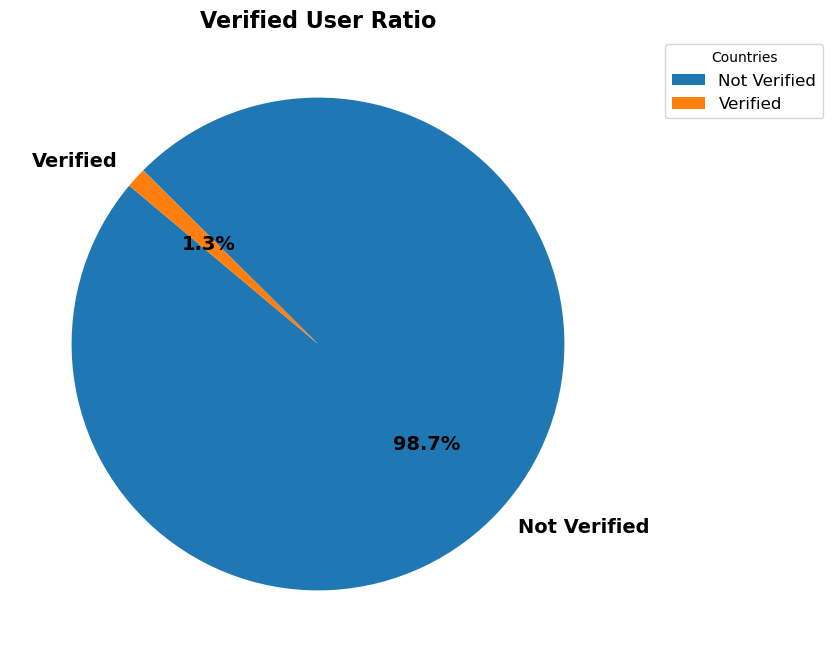

In [12]:
df_verified = df_users.groupby("verified").agg(verified=("user_creation_time", "count"))
df_verified.index = df_verified.index.map(
    lambda x: {True: "Verified", False: "Not Verified"}[x]
    )

plt.figure(figsize=(10, 8))
plt.pie(df_verified["verified"], labels=df_verified.index, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Verified User Ratio", fontsize=16, weight='bold')
plt.legend(df_verified.index, title="Countries", bbox_to_anchor=(1.05, 1),
           loc='upper left', fontsize=12)
df_verified

,default_profile
default_profile,
Unique Profile,1015199
Default Profile,1329792


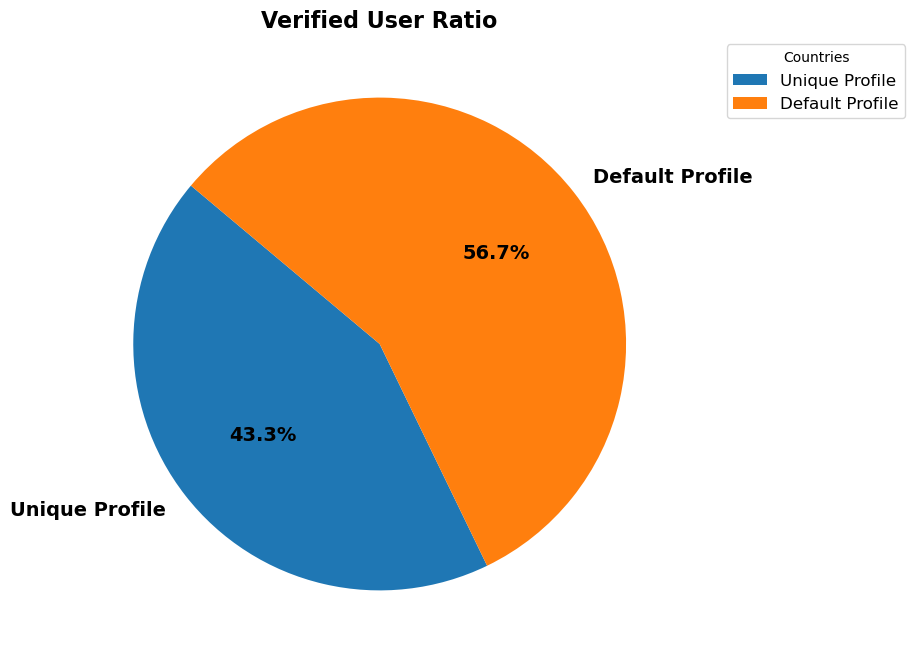

In [13]:
default_profile = df_users.groupby("default_profile").agg(default_profile=("user_creation_time", "count"))
default_profile.index = default_profile.index.map(lambda x: {True: "Default Profile", False: "Unique Profile"}[x])

plt.figure(figsize=(10, 8))
plt.pie(default_profile["default_profile"], labels=default_profile.index,
        autopct='%1.1f%%', startangle=140,
        textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Verified User Ratio", fontsize=16, weight='bold')
plt.legend(default_profile.index, title="Countries", bbox_to_anchor=(1.05, 1),
           loc='upper left', fontsize=12)
default_profile

## Tweets information

,user_id
possibly_sensitive,
Not Sensitive,6113257
Sensitive,34848


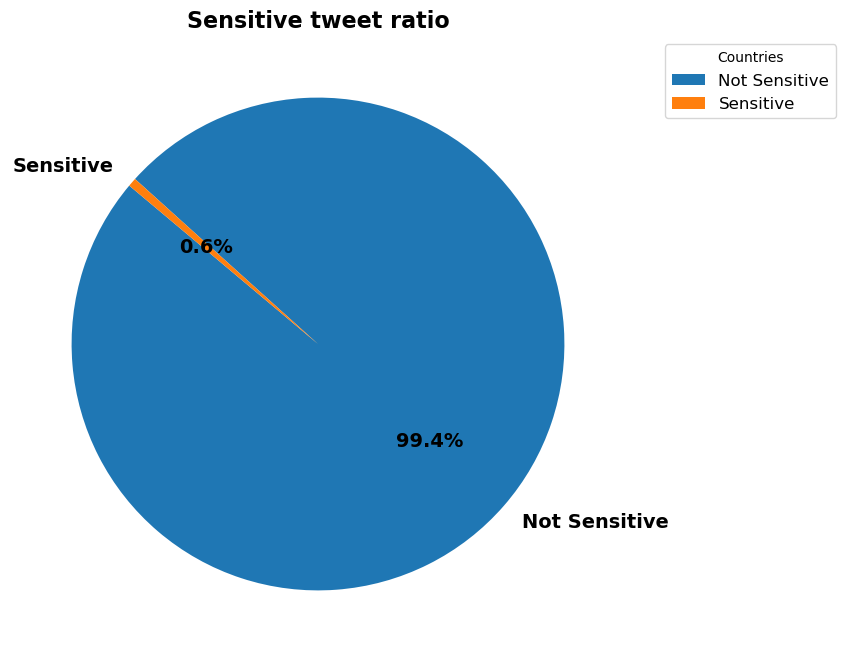

In [14]:
df_sensitive = test_data.groupby("possibly_sensitive")[["user_id"]].count()
df_sensitive.index = df_sensitive.index.map(lambda x: {True: "Sensitive", False: "Not Sensitive"}[x])

plt.figure(figsize=(10, 8))
plt.pie(df_sensitive["user_id"], labels=df_sensitive.index, autopct='%1.1f%%',
        startangle=140, textprops={'fontsize': 14, 'weight': 'bold'})
plt.title("Sensitive tweet ratio", fontsize=16, weight='bold')
plt.legend(df_sensitive.index, title="Countries", bbox_to_anchor=(1.05, 1),
           loc='upper left', fontsize=12)
df_sensitive

# Conversations

In [15]:
convo_special = test_data.sort_values("tweet_creation_time", ascending=False)[["user_id", "replied_tweet_id", "quoted_status_id"]]
convo_special

,user_id,replied_tweet_id,quoted_status_id
tweet_id,,,
1244696713765564416,56784613,None,None
1244696713350217728,1223576386432126976,None,None
1244696710447800320,109284383,None,None
1244696708983984131,246520593,None,None
1244696703690772485,278698748,None,1244398934522392576
...,...,...,...
773181150,10812972,None,None
773176947,10812972,None,None
773176924,10812972,None,None


In [16]:
# v1
from tqdm import tqdm
from collections import defaultdict

class TrieNode:
    def __init__(self):
        self.children = defaultdict(TrieNode)
        self.is_end = False

class Trie:
    def __init__(self):
        self.root = TrieNode()

    def insert(self, conversation):
        node = self.root
        for tweet_id in conversation:
            node = node.children[tweet_id]
        node.is_end = True

    def is_subset(self, conversation):
        node = self.root
        for tweet_id in conversation:
            if tweet_id not in node.children:
                return False
            node = node.children[tweet_id]
        return True



def trace_conversation(start_tweet_id, tweet_dict):
    convo = []
    current_tweet_id = start_tweet_id
    users_in_conversation = set()
    local_processed_tweet_ids = set()  # Local set to track the current conversation
    while current_tweet_id:
        if current_tweet_id not in tweet_dict or current_tweet_id in local_processed_tweet_ids:
            break
        tweet_info = tweet_dict[current_tweet_id]
        convo.append(current_tweet_id)
        users_in_conversation.add(tweet_info['user_id'])
        local_processed_tweet_ids.add(current_tweet_id)
        if len(users_in_conversation) > 2:
            return None  # More than two users, not an exclusive conversation
        current_tweet_id = tweet_info['replied_tweet_id']
    return convo[::-1] if len(users_in_conversation) == 2 else None


def extract_and_filter_conversations(df):
    tweet_dict = df.to_dict('index')
    conversations = []
    trie = Trie()  # Initialize trie for subset checks

    # Start tracing conversations from tweets that are replies
    for tweet_id in tqdm(df[df['replied_tweet_id'].notnull()].index,
                         desc="Extracting all conversations"):
        if conversation := trace_conversation(tweet_id, tweet_dict):
            if not trie.is_subset(conversation):
                trie.insert(conversation)
                conversations.append(conversation)

    return conversations

In [17]:
conversations = extract_and_filter_conversations(convo_special)

python(7219) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Extracting all conversations: 100%|██████████| 1795409/1795409 [00:25<00:00, 70016.54it/s] 


In [18]:
data = []
for convo_num, convo in enumerate(conversations, start=1):
    data.extend((convo_num, tweet_id) for tweet_id in convo)
# Create a DataFrame
df_conversations = pd.DataFrame(data, columns=['Conversation', 'Tweet_ID'])

# Set MultiIndex
df_conversations

,Conversation,Tweet_ID
0,1,1244344799647449089
1,1,1244696491580628993
2,2,1244593729312362497
3,2,1244696406570475525
4,3,1242875007270891523
...,...,...
2206483,864591,451125255294443521
2206484,864592,430790355962052608
2206485,864592,430792524043931648
2206486,864593,248528541157834752


In [19]:

# Merge the conversation DataFrame with the test_data DataFrame
df_conversations_full = df_conversations.merge(test_data, left_on='Tweet_ID', right_index=True, how='left')

# Set the MultiIndex again with Conversation and Tweet_ID
df_conversations_full.set_index(['Conversation', 'Tweet_ID'], inplace=True)
df_conversations_full


user_id  \
Conversation Tweet_ID                                  
1            1244344799647449089  806967414193868800   
             1244696491580628993          2774375013   
2            1244593729312362497           281046179   
             1244696406570475525  907026711010836480   
3            1242875007270891523            22536055   
...                                              ...   
864591       451125255294443521             22536055   
864592       430790355962052608             64327804   
             430792524043931648             22536055   
864593       248528541157834752             19911051   
             248529937198366720            399494759   

                                        user_creation_time  verified  \
Conversation Tweet_ID                                                  
1            1244344799647449089 2016-12-08 21:03:19+00:00     False   
             1244696491580628993 2014-09-18 09:48:49+00:00     False   
2            1244593729312362497 2011-04-12 14:30:18+00:00      True   
             1244696406570475525 2017-09-10 23:43:14+00:00     False   
3            1242875007270891523 2009-03-02 21:23:05+00:00      True   
...                                                    ...       ...   
864591       451125255294443521  2009-03-02 21:23:05+00:00      True   
864592       430790355962052608  2009-08-10 03:34:27+00:00     False   
             430792524043931648  2009-03-02 21:23:05+00:00      True   
864593       248528541157834752  2009-02-02 15:17:02+00:00      True   
             248529937198366720  2011-10-27 15:47:03+00:00     False   

                                  followers_count  friends_count  \
Conversation Tweet_ID                                              
1            1244344799647449089               17            307   
             1244696491580628993              548           1400   
2            1244593729312362497           235796           1623   
             1244696406570475525                1             15   
3            1242875007270891523          1556816         106922   
...                                           ...            ...   
864591       451125255294443521           1556816         106922   
864592       430790355962052608               217            573   
             430792524043931648           1556816         106922   
864593       248528541157834752            246933            789   
             248529937198366720               626           2099   

                                  statuses_count  default_profile  \
Conversation Tweet_ID                                               
1            1244344799647449089              10             True   
             1244696491580628993           14273             True   
2            1244593729312362497          157514            False   
             1244696406570475525               5             True   
3            1242875007270891523         2096661            False   
...                                          ...              ...   
864591       451125255294443521          2096661            False   
864592       430790355962052608             5675             True   
             430792524043931648          2096661            False   
864593       248528541157834752            18849            False   
             248529937198366720             1126            False   

                                  default_profile_image  \
Conversation Tweet_ID                                     
1            1244344799647449089                  False   
             1244696491580628993                  False   
2            1244593729312362497                  False   
             1244696406570475525                  False   
3            1242875007270891523                  False   
...                                                 ...   
864591       451125255294443521                   False   
864592       430790355962052608                   False   
      

In [20]:
airline_conversation = df_conversations_full.loc[df_conversations_full.index.get_level_values('Conversation').isin(df_conversations_full[df_conversations_full['user_id'] == COMPANY_NAME_TO_ID["Lufthansa"]].index.get_level_values('Conversation'))]
airline_conversation

user_id        user_creation_time  \
Conversation Tweet_ID                                                    
144          1244684192040071173    62555545 2009-08-03 16:35:21+00:00   
             1244688444162486273   124476322 2010-03-19 14:30:32+00:00   
             1244689066567794688    62555545 2009-08-03 16:35:21+00:00   
145          1244685953983225857   562252389 2012-04-24 16:49:01+00:00   
             1244689043952209921   124476322 2010-03-19 14:30:32+00:00   
...                                      ...                       ...   
864459       1095473044573700096  1339792290 2013-04-09 17:56:30+00:00   
864465       1090912573304774662   124476322 2010-03-19 14:30:32+00:00   
             1090913775417479168    18631142 2009-01-05 13:13:10+00:00   
864471       1083376699780280321   478699784 2012-01-30 15:32:40+00:00   
             1083381532071469058   124476322 2010-03-19 14:30:32+00:00   

                                  verified  followers_count  friends_count  \
Conversation Tweet_ID                                                        
144          1244684192040071173     False               61             10   
             1244688444162486273      True           427154             31   
             1244689066567794688     False               61             10   
145          1244685953983225857     False              310            531   
             1244689043952209921      True           427154             31   
...                                    ...              ...            ...   
864459       1095473044573700096     False               43            149   
864465       1090912573304774662      True           427154             31   
             1090913775417479168     False               92            405   
864471       1083376699780280321     False              605            981   
             1083381532071469058      True           427154             31   

                                  statuses_count  default_profile  \
Conversation Tweet_ID                                               
144          1244684192040071173             178             True   
             1244688444162486273          102269            False   
             1244689066567794688             178             True   
145          1244685953983225857            5504             True   
             1244689043952209921          102269            False   
...                                          ...              ...   
864459       1095473044573700096             192            False   
864465       1090912573304774662          102269            False   
             1090913775417479168            4111             True   
864471       1083376699780280321            1383            False   
             1083381532071469058          102269            False   

                                  default_profile_image  \
Conversation Tweet_ID                                     
144          1244684192040071173                  False   
             1244688444162486273                  False   
             1244689066567794688                  False   
145          1244685953983225857                  False   
             1244689043952209921                  False   
...                                                 ...   
864459       1095473044573700096                  False   
864465       1090912573304774662                  False   
             1090913775417479168                  False   
864471       1083376699780280321                  False   
             1083381532071469058                  False   

                                       tweet_creation_time  \
Conversation Tweet_ID                                        
144          1244684192040071173 2020-03-30 17:53:31+00:00   
             1244688444162486273 2020-03-30 18:10:24+00:00   
             1244689066567794688 2020-03-30 18:12:53+00:00   
145          1244685953983225857 2020-03-30 18:00:31+00:00   
             12446890

In [21]:
airline_conversation = airline_conversation.reset_index()
airline_conversation['New_Conversation'] = pd.factorize(airline_conversation['Conversation'])[0] + 1
airline_conversation = airline_conversation.set_index(['New_Conversation', 'Tweet_ID'])
airline_conversation = airline_conversation.sort_index(level='New_Conversation')
airline_conversation

Conversation     user_id  \
New_Conversation Tweet_ID                                        
1                1244684192040071173           144    62555545   
                 1244688444162486273           144   124476322   
                 1244689066567794688           144    62555545   
2                1244685953983225857           145   562252389   
                 1244689043952209921           145   124476322   
...                                            ...         ...   
12912            1095473044573700096        864459  1339792290   
12913            1090912573304774662        864465   124476322   
                 1090913775417479168        864465    18631142   
12914            1083376699780280321        864471   478699784   
                 1083381532071469058        864471   124476322   

                                            user_creation_time  verified  \
New_Conversation Tweet_ID                                                  
1                1244684192040071173 2009-08-03 16:35:21+00:00     False   
                 1244688444162486273 2010-03-19 14:30:32+00:00      True   
                 1244689066567794688 2009-08-03 16:35:21+00:00     False   
2                1244685953983225857 2012-04-24 16:49:01+00:00     False   
                 1244689043952209921 2010-03-19 14:30:32+00:00      True   
...                                                        ...       ...   
12912            1095473044573700096 2013-04-09 17:56:30+00:00     False   
12913            1090912573304774662 2010-03-19 14:30:32+00:00      True   
                 1090913775417479168 2009-01-05 13:13:10+00:00     False   
12914            1083376699780280321 2012-01-30 15:32:40+00:00     False   
                 1083381532071469058 2010-03-19 14:30:32+00:00      True   

                                      followers_count  friends_count  \
New_Conversation Tweet_ID                                              
1                1244684192040071173               61             10   
                 1244688444162486273           427154             31   
                 1244689066567794688               61             10   
2                1244685953983225857              310            531   
                 1244689043952209921           427154             31   
...                                               ...            ...   
12912            1095473044573700096               43            149   
12913            1090912573304774662           427154             31   
                 1090913775417479168               92            405   
12914            1083376699780280321              605            981   
                 1083381532071469058           427154             31   

                                      statuses_count  default_profile  \
New_Conversation Tweet_ID                                               
1                1244684192040071173             178             True   
                 1244688444162486273          102269            False   
                 1244689066567794688             178             True   
2                1244685953983225857            5504             True   
                 1244689043952209921          102269            False   
...                                              ...              ...   
12912            1095473044573700096             192            False   
12913            1090912573304774662          102269            False   
                 1090913775417479168            4111             True   
12914            1083376699780280321            1383            False   
                 1083381532071469058          102269            False   

                                      default_profile_image  \
New_Conversation Tweet_ID                                     
1                1244684192040071173                  False   
                 1244688444162486273                  False   
                 1244689066567794688               

# Sentiment Analysis

In [26]:
#Load the tokenizer and model once
model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

#Check if GPU is available
if tf.test.is_gpu_available():
    device = '/GPU:0'
else:
    device = '/CPU:0'

#Set the labels for sentiment results
labels = {
    0 : 'negative',
    1 : 'neutral',
    2 : 'positive'
}

def process_batch(texts):
    """
    Apply sentiment analysis to a batch of texts using a pre-trained transformer model.

    Parameters:
    texts (list): A list of texts to analyze.

    Returns:
    list: A list of ranked sentiment labels for the input texts.

    This function uses a pre-trained transformer model for sequence classification to analyze the sentiment of the texts in the given batch. It returns a list of ranked sentiment labels for the input texts, where the first label is the most likely sentiment and the subsequent labels are less likely sentiments.
    """
    encoded_input = tokenizer(texts, return_tensors='tf', padding=True, truncation=True)
    with tf.device(device):
        output = model(encoded_input)

    scores = output[0].numpy()
    scores = softmax(scores, axis=1)

    sentiment_scores = scores[:, 2] - scores[:, 0]
    return sentiment_scores.tolist()

def apply_sentiment_analysis(df, text_column, batch_size=64, max_workers=4):
    """
    Apply sentiment analysis to the given DataFrame using a pre-trained transformer model.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the text column to analyze.
    text_column (str): The name of the column in the DataFrame containing the text to analyze.
    batch_size (int): The number of texts to process in each batch. Default is 128.
    max_workers (int): The maximum number of worker threads to use for parallel processing. Default is 4.

    Returns:
    pd.DataFrame: The input DataFrame with an additional 'sentiment' column containing the sentiment analysis results.

    This function uses a pre-trained transformer model for sequence classification to analyze the sentiment of the texts in the given DataFrame. It applies the sentiment analysis in parallel using multiple worker threads to improve performance. The results are then added to the input DataFrame as a new 'sentiment' column.
    """
    texts = df[text_column].tolist()
    results = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            results.extend(executor.submit(process_batch, batch).result())

    df['sentiment'] = results
    return df


/Users/jokubas/anaconda3/envs/new_fucking_env/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

All the layers of TFRobertaForSequenceClassification were initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [30]:
pd.set_option('display.max_colwidth', None)  
full_text_df = airline_conversation[['full_text']].copy()
airline_conversation_sample = full_text_df.head(100)
airline_conversation_sample = apply_sentiment_analysis(airline_conversation_sample, 'full_text')
airline_conversation_sample


/var/folders/81/hndg8mlx10316d7lgy0410jr0000gq/T/ipykernel_6630/2732759237.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['sentiment'] = results


full_text  \
New_Conversation Tweet_ID                                                                                                                                                                                                                                                                                                              
1                1244684192040071173          @lufthansa had an email stating changes to my reservation ( you have cancelled my last leg and leaves me stranded in frankfurt ) states about rearranging via phone, but how can I when can't get through, no mention of refund tho, however you've cancelled so im entitled !! Advise   
                 1244688444162486273                                                                              @Holgate1987 At the moment, my colleagues in the Service Center are working on all re-bookings for the next 72 hours. Please reach out to them at a later stage to request a refund https://t.co/eRWyrKTFGQ. /Susi   
                 1244689066567794688                  @lufthansa My fight is in 3 days !!! last time I spoke to a rep 3 weeks ago, they said they would refund me in full, I got an email stating this would happen and nothing, why was I lied to ? They're rebooking for next 72hours so if I call in 4 days I will get a refund ?   
2                1244685953983225857                                                                                                          @lufthansa I requested a refund back on 16/03 and I’m yet to receive any updates. I appreciate your busy I’ve tried calling numerous times for 2hrs plus. Could you give me an update?   
                 1244689043952209921  @AndyHall52 Due to the sheer amount of refund requests needed to be initiated manually by my colleagues, we are unable to predict you with a time frame at the moment, unfortunately. Your patience is highly appreciated, as my colleagues will refund your ticket as soon as possible. /Susi   
...                                                                                                                                                                                                                                                                                                                              ...   
30               1244621137537048577                                                                                                                                                              @cfc_lee According to the current situation and the very volume of requests, the handling might take a bit longer than usual. /Sam   
                 1244621287986692096                                                                                                                                                                                                                                                            @lufthansa How long is a bit longer?   
                 1244625344793055235                                                                                                                                                                                                    @cfc_lee We are unable to provide you with a specific time frame, unfortunately. Sorry! /Mac   
                 1244636359085735936                                                                                                                                                                                                @lufthansa I want MY money the least you can do is tell me when you intend to give it back to me   
31               1241349037795807232                                                                                                                    Hey @Lufthansa_USA @lufthansa - I cancelled my flight within the 24 hour window well over a week ago and still haven’t received my full refund. When can I expect to see it?   

                                      sentiment  
